In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import scipy.stats as stats
from datum import *
import model
import sys

In [2]:
vali_list = []
test_list = []
base_vali_list = []
base_test_list = []

In [3]:
def select(top_num, vali, test):
    vali_abs = np.abs(vali)
    arg_sort = np.argsort(vali_abs)
    select_arg = arg_sort[-top_num:]
    print('minimum: {}'.format(vali[select_arg[0]]))
    select_vali = vali[select_arg]
    select_test = test[select_arg]
    true_test = np.abs(select_test)
    #true_test = np.nan_to_num(select_test * select_vali / np.abs(select_vali))
    print('mean: {}'.format(true_test.mean()))
    return true_test, select_arg

In [4]:
# model_num_list = [54, 120, 77, 136, 115, 137, 60, 106, 195]
model_num_list = [74, 121, 169, 72, 84, 69, 90, 163, 140]

In [4]:
list_data = []
list_mod = []
for i in range(3):
    data = Datum('{}_{}_{}'.format(2004010120140101+i, 2014010120150101, 'year'))
    data.data_prepare()
    data.get_embedding()
    data.supervised_data_prepare()
    data.ic_prepare()
    list_data.append(data)

    reload(model)
    tf.reset_default_graph()
    mod = model.Model(1, '{}_{}_{}'.format(2004010120140101+i, 2014010120150101, 'year'))
    mod.data_initial(data)
    mod.data_split()
    mod.factor_network() 
    list_mod.append(mod)
    
    for j in range(3):
        model_num = j
        saver = tf.train.Saver(max_to_keep=50)
        data_dir = '/data/zhige_data/embedding_simpyear/'
        with tf.Session() as sess:
            saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
            rank_ic = np.zeros((mod.vali_test-mod.train_vali, 44, 4))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            for count_day, day in enumerate(range(mod.train_vali,mod.vali_test)):#batch_num
                for fac_idx in range(44):
                    feature = mod.data.feature_data[:, day, fac_idx]
                    if feature.std() != 0:
                        feature = (feature-feature.min()) / (feature.max() - feature.min())
                    else:
                        continue
                    label = mod.data.ar_ic[:, day, 2]
                    feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
                    new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
                    for ic_idx in range(4):
                        rank_ic[count_day, fac_idx, ic_idx] = stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], new_f)[0]
            vali_ic_mean = rank_ic.mean(axis=0)[:, 2]
            vali_list.append(vali_ic_mean)

            rank_ic = np.zeros((mod.day_sample-mod.vali_test, 44, 4))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            print('test: model:{}'.format(model_num))
            for count_day, day in enumerate(range(mod.vali_test, mod.day_sample)):#batch_num
                for fac_idx in range(44):
                    feature = mod.data.feature_data[:, day, fac_idx]
                    if feature.std() != 0:
                        feature = (feature-feature.min()) / (feature.max() - feature.min())
                    else:
                        continue
                    label = mod.data.ar_ic[:, day, 2]
                    feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
                    new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
                    for ic_idx in range(4):
                        rank_ic[count_day, fac_idx, ic_idx] = stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], new_f)[0]
            avg_ic = rank_ic.mean(axis=0)[:, 2]
            test_list.append(avg_ic)
            print(np.abs(avg_ic))
            print(np.abs(avg_ic).mean())         
    

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2004010120140101_2014010120150101_year/logmodel.ckpt
test: model:0
[0.05947687 0.0140088  0.08050426 0.05027419 0.09639103 0.09739593
 0.07890034 0.03365045 0.00889654 0.02567321 0.04090792 0.00424917
 0.06475691 0.06837967 0.07719096 0.08811046 0.11408932 0.06820676
 0.00637212 0.04639289 0.         0.05865935 0.04090249 0.04716786
 0.01755684 0.0218163  0.         0.11527352 0.10939091 0.11404893
 0.00035795 0.05117877 0.         0.07408397 0.06799592 0.08780542
 0.03976404 0.0043574  0.         0.05428148 0.11607965 0.11695271
 0.0585698  0.10484456]
0.055111719311558255
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2004010120140101_2014010120150101_year/logmodel.ckpt
test: model:1
[0.04861478 0.05969684 0.08756161 0.05347654 0.06092194 0.06153776
 0.02499062 0.01471048 0.09703665 0.10462143 0.05667484 0.00094452
 0.09006857 0.059141   0.07235894 0.08345556 0.0

In [5]:
rank_ic = np.zeros((mod.vali_test-mod.train_vali, 44, 4))
for count_day, day in enumerate(range(mod.train_vali,mod.vali_test)):#batch_num
    for fac_idx in range(44):
        feature = mod.data.feature_data[:, day, fac_idx]
        for ic_idx in range(4):
            rank_ic[count_day, fac_idx, ic_idx] = np.nan_to_num(stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], feature)[0])
vali_ic_mean = rank_ic.mean(axis=0)[:, 2]
base_vali_list.append(vali_ic_mean)           

rank_ic = np.zeros((mod.day_sample-mod.vali_test, 44, 4))
for count_day, day in enumerate(range(mod.vali_test, mod.day_sample)):#batch_num
    for fac_idx in range(44):
        feature = mod.data.feature_data[:, day, fac_idx]
        for ic_idx in range(4):
            rank_ic[count_day, fac_idx, ic_idx] = np.nan_to_num(stats.spearmanr(mod.data.ar_ic[:, day, ic_idx], feature)[0])
avg_ic = rank_ic.mean(axis=0)[:, 2]
base_test_list.append(avg_ic)
print(np.abs(avg_ic))
print(np.abs(avg_ic).mean())             

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


[0.0502181  0.0440199  0.01143306 0.02710887 0.0714651  0.05844293
 0.01780433 0.01168282 0.0557022  0.03344514 0.00627231 0.00354135
 0.03706672 0.03997765 0.05098505 0.05550509 0.02451996 0.00981348
 0.03664483 0.01662877 0.         0.01041357 0.01458295 0.03074057
 0.00199634 0.00359646 0.         0.03005493 0.02857527 0.05291083
 0.02306317 0.01500009 0.         0.01713489 0.02059185 0.04326688
 0.02886007 0.02261416 0.         0.04173175 0.0474862  0.0669866
 0.01593729 0.04322011]
0.02775094619455689


In [60]:
select_fac, select_arg = select(10, base_vali_list[-1], base_test_list[-1])

minimum: -0.0545751454819
mean: 0.01659142034


In [13]:
select_fac, select_arg = select(10, base_vali_list[-1], base_test_list[-1])

minimum: -0.0545751454819
mean: 0.01659142034


In [14]:
mean = 0
for i in range(9):
    select_fac, select_arg = select(10, vali_list[i], test_list[i])
    mean += select_fac.mean()
print(mean / 9)

minimum: -0.0339730178652
mean: 0.0298754754885
minimum: -0.0373978967926
mean: 0.0405774194888
minimum: -0.0371365634515
mean: 0.0419635731394
minimum: -0.0364474752867
mean: 0.0413431474203
minimum: -0.0425383954331
mean: 0.0364402264974
minimum: -0.0334798548638
mean: 0.0522400247479
minimum: -0.0339003164195
mean: 0.0564219443569
minimum: -0.0381342271703
mean: 0.0351002750826
minimum: -0.0376467119545
mean: 0.0437687824046
0.041970096514


In [15]:
select_fac, select_arg = select(10, base_vali_list[-1], base_test_list[-1])

minimum: -0.0550318780993
mean: 0.0247253521618


In [ ]:
mean = 0
for i in range(9):
    select_fac, select_arg = select(10, vali_list[i], test_list[i])
    mean += select_fac.mean()
print(mean / 9)

In [16]:
pd.DataFrame(np.abs(np.array(test_list)).mean(axis=0)).to_csv(data_dir+'test_2014.csv')

In [17]:
pd.DataFrame(np.abs(np.array(base_test_list)).mean(axis=0)).to_csv(data_dir+'baseline_test_2014.csv')

# Visualize Weight

In [6]:
list_confidence = []

for i in range(3):
    data = Datum('{}_{}_{}'.format(2004010120140101+i, 2014010120150101, 'year'))
    data.data_prepare()
    data.get_embedding()
    
    
    reload(model)
    tf.reset_default_graph()
    mod = model.Model(1, '{}_{}_{}'.format(2004010120140101+i, 2014010120150101, 'year'))
    mod.data_initial(data)
    mod.factor_network() 
    
    for j in range(3):
        model_num = j
        saver = tf.train.Saver(max_to_keep=50)
        with tf.Session() as sess:
            saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
            embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
            hold_place = np.zeros(len(mod.data.list_stocks))
            feed_dict = {mod.embedding: embedding, mod.factor: hold_place, mod.factor_index: [0], mod.ic: hold_place}
            u_bias = sess.run(mod.u_bias, feed_dict=feed_dict)
        hidden = np.matmul(embedding, u_bias.T)
        confidence = np.exp(hidden) / np.sum(np.exp(hidden), axis=0)
        list_confidence.append(confidence)

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2004010120140101_2014010120150101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2004010120140101_2014010120150101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/2model_2004010120140101_2014010120150101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2004010120140102_2014010120150101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/1model_2004010120140102_2014010120150101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/2model_2004010120140102_2014010120150101_year/logmodel.ckpt
INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2004010120140103_2014010120150101_year/logmodel.ckpt
INFO:tensorflow:Restoring paramete

In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
for num, confidence in enumerate([list_confidence[0]]):
    print('count: {}'.format(num))
    for fac_idx in range(44):
        print(list_data[0].indicator[fac_idx])
        arg_sort = confidence[:, fac_idx].argsort()
        print('  the max:')
        for arg in arg_sort[-10:]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            print('    ', stock, name, confidence[arg, fac_idx])
        
        print('  the min:')
        for arg in arg_sort[:10]:
            stock = list_data[num].list_stocks[arg]
            try:
                name = data.dict_code2name[stock].split(';')[-2]
            except:
                name = 'not know'
            print('    ', stock, name, confidence[arg, fac_idx])        

count: 0
rise_percent
  the max:
     300336 传媒-新 文 化 0.004349170120953412
     300172 电力及公用事业-中电环保 0.004401079807380189
     300161 机械-华中数控 0.00441044530793743
     300075 计算机-数字政通 0.00446936281610615
     300104 传媒-乐 视 网 0.00519447936345044
     300148 传媒-天舟文化 0.0054010925055071254
     300352 计算机-北 信 源 0.005566928484847673
     300065 国防军工-海 兰 信 0.005736829136637118
     300287 计算机-飞 利 信 0.0065078467345377885
     300253 计算机-卫宁健康 0.00798738159330323
  the min:
     000035 电力及公用事业-中国天楹 1.4100705722175487e-07
     000820 轻工制造-神雾节能 3.4030006270810293e-07
     000622 汽车-恒立实业 3.6517990928583485e-07
     000672 建材-上峰水泥 4.2575618982790383e-07
     000058 房地产-深 赛 格 4.7063387580244535e-07
     000010 建筑-美丽生态 5.640949035004792e-07
     000038 房地产-深 大 通 6.1833676448563e-07
     000757 汽车-浩物股份 6.40167186358513e-07
     000018 房地产-神州长城 7.107414584540232e-07
     002596 建材-海南瑞泽 7.612968076188951e-07
K_length
  the max:
     601877 电力设备-正泰电器 0.0008719790732559445
     002428 有色金属-云南锗业 0.0009014799

     300153 电力设备-科泰电源 3.6466343739108205e-06
     000622 汽车-恒立实业 3.9013783391632714e-06
     000567 房地产-Ｇ 海 德 4.479561799652349e-06
     000429 交通运输-Ｇ粤高速 4.541831852132265e-06
K_line_combination_day
  the max:
     002169 电力设备-智光电气 0.010957114428315057
     300318 医药-博晖创新 0.011119693405007576
     300324 计算机-旋极信息 0.011221818422277272
     002486 纺织服装-嘉 麟 杰 0.012171349068674253
     300148 传媒-天舟文化 0.012516052716013306
     300158 医药-振东制药 0.014591107160754796
     300181 医药-佐力药业 0.017675261616839005
     002577 计算机-雷柏科技 0.01835071219054175
     300272 家电-开能环保 0.01874171528963459
     300246 医药-宝 莱 特 0.019123923054647794
  the min:
     000018 房地产-神州长城 1.1777389120608959e-08
     600093 汽车-易见股份 1.2296704830586616e-08
     600103 轻工制造-青山纸业 1.3293807013539626e-08
     000971 综合-高升控股 2.5699970566122308e-08
     600715 传媒-文投控股 2.8846787700448752e-08
     000156 传媒-华数传媒 2.9422105699426846e-08
     600250 商贸零售-*ST 南纺 3.355234931231699e-08
     600680 通信-*ST 上普 3.909714113580407e-08
     603993 

     000820 轻工制造-神雾节能 3.456935796492462e-05
     300321 基础化工-同大股份 3.563507716539041e-05
     000018 房地产-神州长城 3.611609916486762e-05
     600768 有色金属-S 甬富邦 3.7105273925297685e-05
     000672 建材-上峰水泥 3.925256963947054e-05
middle_low_point_if_exist_day
  the max:
     000151 商贸零售-Ｇ 中 成 0.010111294043399008
     300208 电力设备-恒顺众昇 0.010117810598958108
     002686 机械-亿 利 达 0.010459768931443889
     600215 房地产-长春经开 0.013146049569198293
     002531 电力设备-天顺风能 0.015752060124472514
     002487 电力设备-大金重工 0.021053151484620017
     002514 机械-宝馨科技 0.02166905002876668
     300327 电子元器件-中颖电子 0.02219700379768062
     000615 基础化工-京汉股份 0.02560270913725187
     300269 电子元器件-联建光电 0.09588325708981059
  the min:
     000429 交通运输-Ｇ粤高速 3.415988784231241e-07
     000628 房地产-高新发展 3.5590552401722085e-07
     600007 房地产-Ｇ 国 贸 4.2039321701862296e-07
     600531 有色金属-Ｇ 豫 光 4.65123544481424e-07
     300268 农林牧渔-万福生科 4.782871113670538e-07
     000750 非银行金融-国海证券 5.036232085837648e-07
     600556 房地产-ST 慧 球 5.3152201465333

# Prediction

In [66]:
data = list_data[0]
hushen300 = np.load('stock_code.npy')
rank_info = np.load('rank_info.npy')
use_index = []
label_rank = []

for i in range(len(data.list_stocks)):
    if int(data.list_stocks[i]) in hushen300:
        use_index.append(i)
        label_rank.append(rank_info[:, 0, np.where(hushen300==int(data.list_stocks[i]))[0][0]])
raw_feature = data.feature_data[np.array(use_index), :, :]
date = np.load('date_list.npy')

label_rank = np.array(label_rank)[:, np.where((date >= '2014-01-01') & (date < '2015-01-01'))[0]]
next_return = label_rank

In [67]:
new_feature = np.zeros(data.feature_data.shape)
tf.reset_default_graph()
model_num = 0
mod = list_mod[1]
mod.factor_network() 
saver = tf.train.Saver(max_to_keep=50)
with tf.Session() as sess:
    saver.restore(sess, data_dir+'{}model_{}/logmodel.ckpt'.format(model_num, mod.param))
    embedding = mod.data.embedding[:len(mod.data.list_stocks), :]
    for day in range(mod.day_sample):
        for fac_idx in range(44):
            feature = mod.data.feature_data[:, day, fac_idx]
            if feature.std() != 0:
                feature = (feature-feature.min()) / (feature.max() - feature.min())
            else:
                continue
            label = mod.data.ar_ic[:, day, 2]
            feed_dict = {mod.embedding: embedding, mod.factor: feature, mod.factor_index: [fac_idx], mod.ic: label}
            new_f, loss_val = sess.run([mod.new_f, mod.cost], feed_dict=feed_dict)
            new_feature[:, day, fac_idx] = new_f
new_feature = new_feature[np.array(use_index), :, :]

INFO:tensorflow:Restoring parameters from /data/zhige_data/embedding_simpyear/0model_2004010120140102_2014010120150101_year/logmodel.ckpt


In [68]:

train_raw_feature = raw_feature[:, :mod.train_vali, :].reshape(-1, 44)
vali_raw_feature = raw_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44)
test_raw_feature = raw_feature[:, mod.vali_test:, :].reshape(-1 , 44)

# train_new_feature = np.concatenate((new_feature[:, :mod.train_vali, :].reshape(-1, 44), train_raw_feature), axis=1)
# vali_new_feature = np.concatenate((new_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44), vali_raw_feature), axis=1)
# test_new_feature = np.concatenate((new_feature[:, mod.vali_test:, :].reshape(-1 , 44), test_raw_feature), axis=1)

train_new_feature = new_feature[:, :mod.train_vali, :].reshape(-1, 44)
vali_new_feature = new_feature[:, mod.train_vali:mod.vali_test, :].reshape(-1, 44)
test_new_feature = new_feature[:, mod.vali_test:, :].reshape(-1 , 44)

train_return = next_return[:, :mod.train_vali].reshape(-1)
vali_return = next_return[:, mod.train_vali:mod.vali_test].reshape(-1)
test_return = next_return[:, mod.vali_test:].reshape(-1)

'''
train_raw_feature = raw_feature[:, :mod.train_vali, :]
vali_raw_feature = raw_feature[:, mod.train_vali:mod.vali_test, :]
test_raw_feature = raw_feature[:, mod.vali_test:, :]

train_new_feature = np.concatenate((new_feature[:, :mod.train_vali, :], train_raw_feature), axis=2)
vali_new_feature = np.concatenate((new_feature[:, mod.train_vali:mod.vali_test, :], vali_raw_feature), axis=2)
test_new_feature = np.concatenate((new_feature[:, mod.vali_test:, :], test_raw_feature), axis=2)

train_return = next_return[:, :mod.train_vali]
vali_return = next_return[:, mod.train_vali:mod.vali_test]
test_return = next_return[:, mod.vali_test:]
'''
close_price = data.price_data[use_index, mod.vali_test:]

In [69]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [45]:
def lr_model(train_x, train_y, test_x, test_y):
    '''
    for i in range(train_x.shape[0]):
        train_x[i] = (train_x[i] - train_x[i].mean()) / train_x[i].std()
    for i in range(test_x.shape[0]):
        test_x[i] = (test_x[i] - test_x[i].mean()) / test_x[i].std()        
    '''
    # regr = linear_model.LinearRegression()
    # regr.fit(train_x, train_y)
    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    print("Mean squared error: %.2f" % mean_squared_error(test_y, predict_y))
    print('Variance score: %.2f' % r2_score(test_y, predict_y))
    #print(np.array(mean_error).mean())
    #print(np.array(r2_error).mean())
    return predict_y

In [70]:
def check(price, factor, turn_fee, top):
    money = 10000
    sec_own = np.zeros(factor.shape[0])
    money_sequence = []
    for day in range(price.shape[1]):
        money = money + np.sum(price[:, day] * sec_own)
        money_sequence.append(money)
        fac = factor[:, day]
        arg_sort = np.argsort(-fac)
        soft_max = np.zeros(price.shape[0])
        soft_max[arg_sort[:top]] = 1.0 / top
        # soft_max = np.exp(fac) / np.sum(np.exp(fac))
        
        sec_own_new = money * soft_max / price[:, day]
        change_fee = turn_fee * np.sum(np.abs(sec_own_new - sec_own) * price[:, day])
        money = money - change_fee
        sec_own_new = money * soft_max / price[:, day]
        sec_own = sec_own_new
        money = 0
    earn_rate = np.sum(price[:, day] * sec_own) / 10000
    return (np.power(earn_rate, 4) - 1)
        

In [48]:
raw_fac = lr_model(train_raw_feature, train_return, test_raw_feature, test_return).reshape(165, -1)

Mean squared error: 2447.06
Variance score: -0.06


In [49]:
new_fac = lr_model(train_new_feature, train_return, test_new_feature, test_return).reshape(165, -1)

Mean squared error: 2418.20
Variance score: -0.04


In [63]:
check(close_price, raw_fac, 0, 50)

1.4114147186376447


In [64]:
check(close_price, new_fac, 0, 50)

1.4178660987656992


In [65]:
raw_fac[0]

array([79.07867963, 79.07867963, 79.07867963, 79.07867963, 78.73952575,
       81.87055435, 82.20970823, 82.20970823, 82.20970823, 82.20970823,
       83.86516377, 83.29823504, 82.95908117, 82.95908117, 82.95908117,
       81.87055435, 81.87055435, 81.87055435, 83.75083248, 83.75083248,
       83.75083248, 83.54773359, 82.67475203, 82.67475203, 83.01390591,
       80.59237504, 79.51143593, 80.2965272 , 81.49446811, 79.68962449,
       80.413529  , 81.49446811, 81.49446811, 79.68962449, 79.68962449,
       79.68962449, 75.57580338, 75.57580338, 75.3727045 , 76.43732286,
       76.31396635, 68.23978229, 67.9684657 , 66.00018723, 66.00018723,
       62.27349042, 63.32217645, 62.27349042, 66.9058735 , 64.34641198,
       64.72096827, 70.65578398, 70.65578398, 70.65578398, 70.65578398,
       69.54959802, 71.05168773, 69.54959802, 69.54959802, 69.10926729,
       74.36508373, 78.98159579])

# hyper paramter test

In [76]:
close_price = data.price_data[use_index, mod.train_vali:mod.vali_test]

In [77]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

In [85]:
estimators = [50, 100, 200, 300, 500, 800, 1000]
max_depths = [1, 2, 4, 6, 8, 10]
learning_rates = [0.0001, 0.001, 0.1, 0.5, 1, 5]
top_ks = [10, 20, 30, 40, 50, 70, 100]

In [82]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, vali_raw_feature, vali_return] 
result_list = []
for estimator in estimators:
    for dep in max_depths:
        for lr in learning_rates:
            params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
                  'learning_rate': lr, 'loss': 'ls'}
            clf = ensemble.GradientBoostingRegressor(**params)   
            clf.fit(train_x, train_y)
            predict_y = clf.predict(test_x).reshape(165, -1)
            for top in top_k:
                result = check(close_price, predict_y, 0, top)
                print(estimator, dep, lr, top, result)
                result_list.append(result)

(50, 1, 0.0001, 10, 1.459063431113985)
(50, 1, 0.0001, 20, 1.4233657161747382)
(50, 1, 0.0001, 30, 1.3469950531818609)
(50, 1, 0.0001, 40, 1.4119239571301185)
(50, 1, 0.0001, 50, 1.4612586470299327)
(50, 1, 0.0001, 70, 1.3835623677867117)
(50, 1, 0.0001, 100, 1.1685170172288646)
(50, 1, 0.001, 10, 1.459063431113985)
(50, 1, 0.001, 20, 1.4233657161747382)
(50, 1, 0.001, 30, 1.3469950531818609)
(50, 1, 0.001, 40, 1.4119239571301185)
(50, 1, 0.001, 50, 1.4612586470299327)
(50, 1, 0.001, 70, 1.3835623677867117)
(50, 1, 0.001, 100, 1.1685170172288646)
(50, 1, 0.1, 10, 1.1073707665242019)
(50, 1, 0.1, 20, 1.339667439813745)
(50, 1, 0.1, 30, 1.1339908330732569)
(50, 1, 0.1, 40, 1.1806406715938036)
(50, 1, 0.1, 50, 1.1455003413552935)
(50, 1, 0.1, 70, 1.2410201651545818)
(50, 1, 0.1, 100, 1.1593403906308577)
(50, 1, 0.5, 10, 1.5411678450303836)
(50, 1, 0.5, 20, 1.6049425431354156)
(50, 1, 0.5, 30, 1.2022987603981603)
(50, 1, 0.5, 40, 1.1552664103281334)
(50, 1, 0.5, 50, 1.0648095023951942)
(50

(50, 10, 0.1, 10, 1.4617764318329902)
(50, 10, 0.1, 20, 1.609816096059959)
(50, 10, 0.1, 30, 1.516559453504799)
(50, 10, 0.1, 40, 1.466947388314586)
(50, 10, 0.1, 50, 1.4024601205306357)
(50, 10, 0.1, 70, 1.3133204646065955)
(50, 10, 0.1, 100, 1.3522322982655894)
(50, 10, 0.5, 10, 1.1261910359864293)
(50, 10, 0.5, 20, 1.3262880801632928)
(50, 10, 0.5, 30, 1.2309966394877643)
(50, 10, 0.5, 40, 1.2712722000969219)
(50, 10, 0.5, 50, 1.2088940309696938)
(50, 10, 0.5, 70, 1.151613603211029)
(50, 10, 0.5, 100, 1.0134294444875653)
(50, 10, 1, 10, 0.8914084191202016)
(50, 10, 1, 20, 0.994993384432614)
(50, 10, 1, 30, 1.055242093572983)
(50, 10, 1, 40, 1.115071119521092)
(50, 10, 1, 50, 1.1402490444868456)
(50, 10, 1, 70, 1.0739474579254487)
(50, 10, 1, 100, 1.0377299083947693)
(50, 10, 5, 10, 1.0366308419435248)
(50, 10, 5, 20, 1.1642574158112575)
(50, 10, 5, 30, 1.0686146277630235)
(50, 10, 5, 40, 0.8894277106204569)
(50, 10, 5, 50, 0.9638907744344944)
(50, 10, 5, 70, 0.8862270033392512)
(50,

(100, 8, 0.5, 10, 1.7390577415606439)
(100, 8, 0.5, 20, 1.2715490070200892)
(100, 8, 0.5, 30, 1.0930674228892014)
(100, 8, 0.5, 40, 1.183262458509816)
(100, 8, 0.5, 50, 1.2462717743768024)
(100, 8, 0.5, 70, 1.2196981782536875)
(100, 8, 0.5, 100, 1.210587029388492)
(100, 8, 1, 10, 0.9253231116576521)
(100, 8, 1, 20, 1.1631375175335408)
(100, 8, 1, 30, 1.1777241717978542)
(100, 8, 1, 40, 1.2694362544614686)
(100, 8, 1, 50, 1.276413554989495)
(100, 8, 1, 70, 1.1565631130365226)
(100, 8, 1, 100, 1.1077059662368192)
(100, 8, 5, 10, 0.6200838424947626)
(100, 8, 5, 20, 0.7664811803138225)
(100, 8, 5, 30, 0.7717240737550328)
(100, 8, 5, 40, 0.8513883808863356)
(100, 8, 5, 50, 0.9042382050624838)
(100, 8, 5, 70, 0.9337487703768081)
(100, 8, 5, 100, 0.9345180411875333)
(100, 10, 0.0001, 10, 0.934422215651042)
(100, 10, 0.0001, 20, 1.4033733389640268)
(100, 10, 0.0001, 30, 1.15104761469643)
(100, 10, 0.0001, 40, 1.135679641739618)
(100, 10, 0.0001, 50, 1.1499593056895057)
(100, 10, 0.0001, 70, 1.

(200, 6, 1, 10, 2.0383001740979183)
(200, 6, 1, 20, 1.481508518298397)
(200, 6, 1, 30, 1.2980953048714183)
(200, 6, 1, 40, 1.304466049466551)
(200, 6, 1, 50, 1.1682341782079262)
(200, 6, 1, 70, 1.230843684955365)
(200, 6, 1, 100, 1.0996165851659963)
(200, 6, 5, 10, 0.24836161410219493)
(200, 6, 5, 20, 0.4741824533773513)
(200, 6, 5, 30, 0.5700733856402791)
(200, 6, 5, 40, 0.6296501229116902)
(200, 6, 5, 50, 0.6279526839892684)
(200, 6, 5, 70, 0.8010185837044117)
(200, 6, 5, 100, 0.9326144314039533)
(200, 8, 0.0001, 10, 0.7127589380425858)
(200, 8, 0.0001, 20, 0.9375217573226031)
(200, 8, 0.0001, 30, 1.1804534753104572)
(200, 8, 0.0001, 40, 1.167001622643788)
(200, 8, 0.0001, 50, 1.2058890569714875)
(200, 8, 0.0001, 70, 1.2776137128120721)
(200, 8, 0.0001, 100, 1.136279309627469)
(200, 8, 0.001, 10, 0.8092192229654225)
(200, 8, 0.001, 20, 1.307538040214466)
(200, 8, 0.001, 30, 1.4483961120230098)
(200, 8, 0.001, 40, 1.2324929847157673)
(200, 8, 0.001, 50, 1.2690748349726362)
(200, 8, 0.

(300, 4, 5, 10, 1.0957543760290869)
(300, 4, 5, 20, 1.6681614907853417)
(300, 4, 5, 30, 1.5765270455376403)
(300, 4, 5, 40, 1.2554358540910124)
(300, 4, 5, 50, 1.15089250733705)
(300, 4, 5, 70, 0.9651388046910854)
(300, 4, 5, 100, 0.9688148887775654)
(300, 6, 0.0001, 10, 0.5184227439355318)
(300, 6, 0.0001, 20, 1.342600397464008)
(300, 6, 0.0001, 30, 1.3865418635347893)
(300, 6, 0.0001, 40, 1.1969744854877318)
(300, 6, 0.0001, 50, 1.3132372324666264)
(300, 6, 0.0001, 70, 1.237534435839541)
(300, 6, 0.0001, 100, 1.0631810078053543)
(300, 6, 0.001, 10, 1.1284716120166909)
(300, 6, 0.001, 20, 0.9781323178101624)
(300, 6, 0.001, 30, 1.19295650620181)
(300, 6, 0.001, 40, 1.1542149197943021)
(300, 6, 0.001, 50, 1.102255212958791)
(300, 6, 0.001, 70, 1.1920582434621272)
(300, 6, 0.001, 100, 1.1817022618249426)
(300, 6, 0.1, 10, 1.4363717645071925)
(300, 6, 0.1, 20, 1.450477658302081)
(300, 6, 0.1, 30, 1.4609775764574633)
(300, 6, 0.1, 40, 1.4903694461405768)
(300, 6, 0.1, 50, 1.45453475887398

(500, 4, 0.0001, 10, 1.6536217360446948)
(500, 4, 0.0001, 20, 1.1083741788225172)
(500, 4, 0.0001, 30, 1.0556167862659862)
(500, 4, 0.0001, 40, 1.1320448761146737)
(500, 4, 0.0001, 50, 1.0261694697708168)
(500, 4, 0.0001, 70, 1.145760867165496)
(500, 4, 0.0001, 100, 1.2417375204810779)
(500, 4, 0.001, 10, 0.6413507732016166)
(500, 4, 0.001, 20, 1.046559572868968)
(500, 4, 0.001, 30, 1.0575499220676794)
(500, 4, 0.001, 40, 1.0493401818465418)
(500, 4, 0.001, 50, 1.1082307132175666)
(500, 4, 0.001, 70, 1.1104610023270887)
(500, 4, 0.001, 100, 1.0819009028138709)
(500, 4, 0.1, 10, 1.4793088717680778)
(500, 4, 0.1, 20, 1.8339115724683617)
(500, 4, 0.1, 30, 1.777664317488954)
(500, 4, 0.1, 40, 1.4818640370663596)
(500, 4, 0.1, 50, 1.3488888254365081)
(500, 4, 0.1, 70, 1.2806549224137687)
(500, 4, 0.1, 100, 1.2004853072271935)
(500, 4, 0.5, 10, 2.4422450120325307)
(500, 4, 0.5, 20, 1.8377085990748405)
(500, 4, 0.5, 30, 1.455287852642253)
(500, 4, 0.5, 40, 1.531096435980202)
(500, 4, 0.5, 50,

(800, 2, 0.001, 10, 2.5195468194995)
(800, 2, 0.001, 20, 1.9293465392317635)
(800, 2, 0.001, 30, 1.4950433478920409)
(800, 2, 0.001, 40, 1.1344275235953432)
(800, 2, 0.001, 50, 1.1387859879925588)
(800, 2, 0.001, 70, 1.1611695331784615)
(800, 2, 0.001, 100, 1.1024452000872906)
(800, 2, 0.1, 10, 1.5450955177148566)
(800, 2, 0.1, 20, 1.7807286457280016)
(800, 2, 0.1, 30, 1.5516589903151736)
(800, 2, 0.1, 40, 1.3924454110987683)
(800, 2, 0.1, 50, 1.2590609711515635)
(800, 2, 0.1, 70, 1.212518101695221)
(800, 2, 0.1, 100, 1.1104595304437437)
(800, 2, 0.5, 10, 1.8162976219104014)
(800, 2, 0.5, 20, 1.5474936970155122)
(800, 2, 0.5, 30, 1.3727594383581625)
(800, 2, 0.5, 40, 1.2320687055515416)
(800, 2, 0.5, 50, 1.2288309027283488)
(800, 2, 0.5, 70, 1.2586226799751765)
(800, 2, 0.5, 100, 1.2073504429107387)
(800, 2, 1, 10, 1.2834777539195446)
(800, 2, 1, 20, 1.1012622247681518)
(800, 2, 1, 30, 1.0628525649067564)
(800, 2, 1, 40, 1.044044277907099)
(800, 2, 1, 50, 1.1247040566194588)
(800, 2, 1

(1000, 1, 0.1, 10, 1.573377562639378)
(1000, 1, 0.1, 20, 1.4963901790871894)
(1000, 1, 0.1, 30, 1.4253491343749558)
(1000, 1, 0.1, 40, 1.3355142808463936)
(1000, 1, 0.1, 50, 1.144843481477574)
(1000, 1, 0.1, 70, 1.009036728321945)
(1000, 1, 0.1, 100, 0.9949918529217381)
(1000, 1, 0.5, 10, 1.1740432195902892)
(1000, 1, 0.5, 20, 1.2365001235474087)
(1000, 1, 0.5, 30, 1.3541036662624446)
(1000, 1, 0.5, 40, 1.4494452732336733)
(1000, 1, 0.5, 50, 1.3816632224131813)
(1000, 1, 0.5, 70, 1.2440143710100204)
(1000, 1, 0.5, 100, 1.1059369064474338)
(1000, 1, 1, 10, 1.4339644940360303)
(1000, 1, 1, 20, 1.3848816017659287)
(1000, 1, 1, 30, 1.4547679544766416)
(1000, 1, 1, 40, 1.3870841028457521)
(1000, 1, 1, 50, 1.2726370244970124)
(1000, 1, 1, 70, 1.3182652561408044)
(1000, 1, 1, 100, 1.189609574339741)
(1000, 1, 5, 10, 0.9701899551705817)
(1000, 1, 5, 20, 0.9275006134437067)
(1000, 1, 5, 30, 1.1227402368333177)
(1000, 1, 5, 40, 1.1731463944724734)
(1000, 1, 5, 50, 1.2900348770417729)
(1000, 1, 5

(1000, 10, 0.1, 10, 1.783763025058525)
(1000, 10, 0.1, 20, 1.691985698259578)
(1000, 10, 0.1, 30, 1.6063385574720543)
(1000, 10, 0.1, 40, 1.4601653397163021)
(1000, 10, 0.1, 50, 1.5196975153878345)
(1000, 10, 0.1, 70, 1.4868471962812482)
(1000, 10, 0.1, 100, 1.3278773965395274)
(1000, 10, 0.5, 10, 1.290570727447994)
(1000, 10, 0.5, 20, 1.231923081915519)
(1000, 10, 0.5, 30, 1.3338339848364895)
(1000, 10, 0.5, 40, 1.5224956608253288)
(1000, 10, 0.5, 50, 1.300715819532722)
(1000, 10, 0.5, 70, 1.1353963141985224)
(1000, 10, 0.5, 100, 1.15158872268763)
(1000, 10, 1, 10, 1.5093230987872608)
(1000, 10, 1, 20, 1.3210254295646657)
(1000, 10, 1, 30, 1.1879901466886547)
(1000, 10, 1, 40, 1.2640041595255878)
(1000, 10, 1, 50, 1.2343257601152708)
(1000, 10, 1, 70, 1.0705047662045364)
(1000, 10, 1, 100, 1.0432254556018354)
(1000, 10, 5, 10, 0.9701899551705817)
(1000, 10, 5, 20, 0.9275006134437067)
(1000, 10, 5, 30, 1.1227402368333177)
(1000, 10, 5, 40, 1.1731463944724734)
(1000, 10, 5, 50, 1.290034

In [81]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, vali_new_feature, vali_return] 
new_result_list = []
for estimator in estimators:
    for dep in max_depths:
        for lr in learning_rates:
            
            params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
                  'learning_rate': lr, 'loss': 'ls'}
            clf = ensemble.GradientBoostingRegressor(**params)   
            clf.fit(train_x, train_y)
            predict_y = clf.predict(test_x).reshape(165, -1)
            for top in top_k:
                result = check(close_price, predict_y, 0, top)
                print(estimator, dep, lr, top, result)
                new_result_list.append(result)

(50, 1, 0.0001, 10, 1.0263118530208648)
(50, 1, 0.0001, 20, 1.2064625053035303)
(50, 1, 0.0001, 30, 1.182233423056664)
(50, 1, 0.0001, 40, 1.2581647388017463)
(50, 1, 0.0001, 50, 1.4041513417412732)
(50, 1, 0.0001, 70, 1.3943555326854828)
(50, 1, 0.0001, 100, 1.1447812420634151)
(50, 1, 0.001, 10, 1.0263118530208648)
(50, 1, 0.001, 20, 1.2064625053035303)
(50, 1, 0.001, 30, 1.182233423056664)
(50, 1, 0.001, 40, 1.2581647388017463)
(50, 1, 0.001, 50, 1.4041513417412732)
(50, 1, 0.001, 70, 1.3943555326854828)
(50, 1, 0.001, 100, 1.1447812420634151)
(50, 1, 0.1, 10, 0.7469467014750935)
(50, 1, 0.1, 20, 1.5113321355740217)
(50, 1, 0.1, 30, 1.4949089705312044)
(50, 1, 0.1, 40, 1.3759086937700897)
(50, 1, 0.1, 50, 1.3760260737625094)
(50, 1, 0.1, 70, 1.2422339536482316)
(50, 1, 0.1, 100, 1.0881173727914097)
(50, 1, 0.5, 10, 1.0726887788069255)
(50, 1, 0.5, 20, 1.217687263303164)
(50, 1, 0.5, 30, 1.169843847715129)
(50, 1, 0.5, 40, 1.2043173262246563)
(50, 1, 0.5, 50, 1.2529727803627968)
(50,

(50, 10, 0.1, 10, 2.711340951990565)
(50, 10, 0.1, 20, 1.8124823164865442)
(50, 10, 0.1, 30, 1.4493311203749393)
(50, 10, 0.1, 40, 1.3766110431943104)
(50, 10, 0.1, 50, 1.3572951876434303)
(50, 10, 0.1, 70, 1.1970966141144976)
(50, 10, 0.1, 100, 1.2254238045108297)
(50, 10, 0.5, 10, 1.6134807895474177)
(50, 10, 0.5, 20, 2.002445611361538)
(50, 10, 0.5, 30, 1.8011800648255996)
(50, 10, 0.5, 40, 1.4155069961996731)
(50, 10, 0.5, 50, 1.2986602831608534)
(50, 10, 0.5, 70, 1.1777022175802334)
(50, 10, 0.5, 100, 1.1383554242169205)
(50, 10, 1, 10, 1.7174114591032033)
(50, 10, 1, 20, 0.9496992399120581)
(50, 10, 1, 30, 1.0790452823112395)
(50, 10, 1, 40, 1.0653513508334087)
(50, 10, 1, 50, 1.1342855352564714)
(50, 10, 1, 70, 1.0267626880182341)
(50, 10, 1, 100, 1.0174602036738127)
(50, 10, 5, 10, 0.2815006897151069)
(50, 10, 5, 20, 0.37516169177322456)
(50, 10, 5, 30, 0.5516050127998231)
(50, 10, 5, 40, 0.6492387510923527)
(50, 10, 5, 50, 0.5724209694239906)
(50, 10, 5, 70, 0.783070303854027)

(100, 8, 0.5, 10, 1.4607612782061645)
(100, 8, 0.5, 20, 1.6530962649250882)
(100, 8, 0.5, 30, 1.3808765453718488)
(100, 8, 0.5, 40, 1.2717660813922689)
(100, 8, 0.5, 50, 1.2294414957018587)
(100, 8, 0.5, 70, 1.1625842222453326)
(100, 8, 0.5, 100, 0.9934635635376374)
(100, 8, 1, 10, 1.358031336732628)
(100, 8, 1, 20, 1.177314825656354)
(100, 8, 1, 30, 1.1625877151026862)
(100, 8, 1, 40, 1.1788675588668043)
(100, 8, 1, 50, 1.1797356289018146)
(100, 8, 1, 70, 1.0677294041648326)
(100, 8, 1, 100, 1.0358639436181987)
(100, 8, 5, 10, 0.18597131944251344)
(100, 8, 5, 20, 0.5494385315580559)
(100, 8, 5, 30, 0.7432094314668336)
(100, 8, 5, 40, 0.8136917901338148)
(100, 8, 5, 50, 0.8511106457227013)
(100, 8, 5, 70, 0.7804282396433593)
(100, 8, 5, 100, 0.8294810180473642)
(100, 10, 0.0001, 10, 0.9850939688560689)
(100, 10, 0.0001, 20, 1.14900145147236)
(100, 10, 0.0001, 30, 1.2170110086435644)
(100, 10, 0.0001, 40, 1.2009126965963373)
(100, 10, 0.0001, 50, 1.1655731048456044)
(100, 10, 0.0001, 70

(200, 6, 1, 10, 1.7979553980440075)
(200, 6, 1, 20, 1.3939886999366982)
(200, 6, 1, 30, 1.4000327566042983)
(200, 6, 1, 40, 1.299871536429956)
(200, 6, 1, 50, 1.164272028497047)
(200, 6, 1, 70, 1.0355640109978346)
(200, 6, 1, 100, 1.0549601658713859)
(200, 6, 5, 10, 0.3248310624791453)
(200, 6, 5, 20, 0.37228738097757663)
(200, 6, 5, 30, 0.47042997810323706)
(200, 6, 5, 40, 0.6009995482879666)
(200, 6, 5, 50, 0.7316072516335601)
(200, 6, 5, 70, 0.8409134935125075)
(200, 6, 5, 100, 0.826096669609186)
(200, 8, 0.0001, 10, 1.1737528911689967)
(200, 8, 0.0001, 20, 0.974078696681735)
(200, 8, 0.0001, 30, 1.04879882813094)
(200, 8, 0.0001, 40, 0.9381653358999529)
(200, 8, 0.0001, 50, 1.0511703455137567)
(200, 8, 0.0001, 70, 1.0914074023502298)
(200, 8, 0.0001, 100, 1.0558107722086456)
(200, 8, 0.001, 10, 1.2718192055034367)
(200, 8, 0.001, 20, 1.07107039892368)
(200, 8, 0.001, 30, 1.0312909303906443)
(200, 8, 0.001, 40, 1.2185167428538208)
(200, 8, 0.001, 50, 1.1520344261954354)
(200, 8, 0.0

(300, 4, 5, 10, 1.3222599224874942)
(300, 4, 5, 20, 1.1408825282564479)
(300, 4, 5, 30, 1.1891278620106225)
(300, 4, 5, 40, 1.1398833974893345)
(300, 4, 5, 50, 0.9826544466168619)
(300, 4, 5, 70, 0.8722579404596027)
(300, 4, 5, 100, 0.8681456926872992)
(300, 6, 0.0001, 10, 1.7082335158010298)
(300, 6, 0.0001, 20, 1.213526517298706)
(300, 6, 0.0001, 30, 1.176284726800025)
(300, 6, 0.0001, 40, 1.105278791857498)
(300, 6, 0.0001, 50, 1.2465040991915566)
(300, 6, 0.0001, 70, 1.2449852607365823)
(300, 6, 0.0001, 100, 1.0394974411080735)
(300, 6, 0.001, 10, 2.0173977947231316)
(300, 6, 0.001, 20, 1.8306941146716604)
(300, 6, 0.001, 30, 1.58810447770917)
(300, 6, 0.001, 40, 1.541468481884591)
(300, 6, 0.001, 50, 1.3770118888683918)
(300, 6, 0.001, 70, 1.319432254272062)
(300, 6, 0.001, 100, 1.219042290705779)
(300, 6, 0.1, 10, 2.529186597667017)
(300, 6, 0.1, 20, 2.0205997506392155)
(300, 6, 0.1, 30, 1.6737670464731975)
(300, 6, 0.1, 40, 1.4286048948370254)
(300, 6, 0.1, 50, 1.364010619184552

(500, 4, 0.0001, 10, 0.6081617174770562)
(500, 4, 0.0001, 20, 0.8996899723728005)
(500, 4, 0.0001, 30, 1.163739852424038)
(500, 4, 0.0001, 40, 1.2548464471963134)
(500, 4, 0.0001, 50, 1.1917712928620507)
(500, 4, 0.0001, 70, 1.075426004507516)
(500, 4, 0.0001, 100, 1.0009480531564128)
(500, 4, 0.001, 10, 1.5563845606386066)
(500, 4, 0.001, 20, 1.4731848377521586)
(500, 4, 0.001, 30, 1.4973429666434517)
(500, 4, 0.001, 40, 1.5440239375311235)
(500, 4, 0.001, 50, 1.4106406247840333)
(500, 4, 0.001, 70, 1.2163873684887334)
(500, 4, 0.001, 100, 1.1560188493515242)
(500, 4, 0.1, 10, 2.065587456412637)
(500, 4, 0.1, 20, 1.8407021098950942)
(500, 4, 0.1, 30, 1.4162233551760357)
(500, 4, 0.1, 40, 1.1958926175830107)
(500, 4, 0.1, 50, 1.2026744751077691)
(500, 4, 0.1, 70, 1.173071067179205)
(500, 4, 0.1, 100, 1.1621562669518952)
(500, 4, 0.5, 10, 3.796760236911685)
(500, 4, 0.5, 20, 2.8536516992677954)
(500, 4, 0.5, 30, 2.0282889252867364)
(500, 4, 0.5, 40, 1.7760101279429374)
(500, 4, 0.5, 50,

(800, 2, 0.001, 10, 1.0563903169313664)
(800, 2, 0.001, 20, 1.7199288685220049)
(800, 2, 0.001, 30, 1.4084654319271035)
(800, 2, 0.001, 40, 1.2751324290071908)
(800, 2, 0.001, 50, 1.3233961325258772)
(800, 2, 0.001, 70, 1.307176806687044)
(800, 2, 0.001, 100, 1.2312376528431552)
(800, 2, 0.1, 10, 2.1302928166213833)
(800, 2, 0.1, 20, 1.8197221101520955)
(800, 2, 0.1, 30, 1.5362490532961242)
(800, 2, 0.1, 40, 1.4208984062123133)
(800, 2, 0.1, 50, 1.2969116776123606)
(800, 2, 0.1, 70, 1.134371834533054)
(800, 2, 0.1, 100, 1.157477049489895)
(800, 2, 0.5, 10, 3.218022361004037)
(800, 2, 0.5, 20, 2.2612157464509632)
(800, 2, 0.5, 30, 1.9392673586019096)
(800, 2, 0.5, 40, 1.7130893703279186)
(800, 2, 0.5, 50, 1.5571894916662825)
(800, 2, 0.5, 70, 1.3489629761433557)
(800, 2, 0.5, 100, 1.3117186879791687)
(800, 2, 1, 10, 1.5712591250262329)
(800, 2, 1, 20, 1.3615646551087992)
(800, 2, 1, 30, 1.299550274911629)
(800, 2, 1, 40, 1.1210673621802898)
(800, 2, 1, 50, 1.0906064133804971)
(800, 2, 1

(1000, 1, 0.1, 10, 1.5525682441411561)
(1000, 1, 0.1, 20, 1.4684006976168393)
(1000, 1, 0.1, 30, 1.383087455839314)
(1000, 1, 0.1, 40, 1.3151534892949193)
(1000, 1, 0.1, 50, 1.303903512483112)
(1000, 1, 0.1, 70, 1.1850452512364753)
(1000, 1, 0.1, 100, 1.0788843559158448)
(1000, 1, 0.5, 10, 1.4918236507273916)
(1000, 1, 0.5, 20, 1.7415063720001553)
(1000, 1, 0.5, 30, 1.6077986833155888)
(1000, 1, 0.5, 40, 1.3496658047169148)
(1000, 1, 0.5, 50, 1.3352529122197336)
(1000, 1, 0.5, 70, 1.1316034647436486)
(1000, 1, 0.5, 100, 1.1011062128638223)
(1000, 1, 1, 10, 1.836117005273954)
(1000, 1, 1, 20, 1.6354878002227227)
(1000, 1, 1, 30, 1.6147815335533808)
(1000, 1, 1, 40, 1.5437661651575332)
(1000, 1, 1, 50, 1.5174661655602861)
(1000, 1, 1, 70, 1.2973223849606845)
(1000, 1, 1, 100, 1.2432305187285686)
(1000, 1, 5, 10, 0.9701899551705817)
(1000, 1, 5, 20, 0.9275006134437067)
(1000, 1, 5, 30, 1.1227402368333177)
(1000, 1, 5, 40, 1.1731463944724734)
(1000, 1, 5, 50, 1.2900348770417729)
(1000, 1, 

(1000, 10, 0.1, 10, 2.4794917354366586)
(1000, 10, 0.1, 20, 2.0269084193318485)
(1000, 10, 0.1, 30, 1.7494240252508786)
(1000, 10, 0.1, 40, 1.4836708967508976)
(1000, 10, 0.1, 50, 1.3470912886716686)
(1000, 10, 0.1, 70, 1.2016546382867772)
(1000, 10, 0.1, 100, 1.2222054674930045)
(1000, 10, 0.5, 10, 1.032586051125194)
(1000, 10, 0.5, 20, 1.4587504449065918)
(1000, 10, 0.5, 30, 1.4692594801160515)
(1000, 10, 0.5, 40, 1.3091509500962526)
(1000, 10, 0.5, 50, 1.2469859036612352)
(1000, 10, 0.5, 70, 1.1084772970791184)
(1000, 10, 0.5, 100, 1.0927987399272356)
(1000, 10, 1, 10, 0.6678585323829056)
(1000, 10, 1, 20, 1.1923930529618758)
(1000, 10, 1, 30, 1.1596566298369861)
(1000, 10, 1, 40, 1.0984747886333341)
(1000, 10, 1, 50, 1.0354454919402936)
(1000, 10, 1, 70, 1.0227298760881438)
(1000, 10, 1, 100, 1.0174629357707143)
(1000, 10, 5, 10, 0.9701899551705817)
(1000, 10, 5, 20, 0.9275006134437067)
(1000, 10, 5, 30, 1.1227402368333177)
(1000, 10, 5, 40, 1.1731463944724734)
(1000, 10, 5, 50, 1.

In [84]:
def get_param(num):
    topk = num % 7
    num = (num - 7 * topk) // 7
    lr = num % 6
    num = (num - 6 * lr) // 6
    dep = num % 6
    num = (num - 6 * dep) // 6
    estimate = num % 7
    return estimators[int(estimate)], max_depths[int(dep)], learning_rates[int(lr)], top_ks[int(topk)]
    

In [90]:
close_price = data.price_data[use_index, mod.vali_test:]
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
select_result = []
a_result = np.array(result_list)
arg_result = np.argsort(-a_result)
n = 10
for arg in arg_result[:n]:
    estimator, dep, lr, topk = get_param(arg)
    params = {'n_estimators': int(estimator), 'max_depth': int(dep), 'min_samples_split': 2,
          'learning_rate': lr, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)   
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x).reshape(165, -1)
    result = check(close_price, predict_y, 0, top)
    print(estimator, dep, lr, top, result)
    select_result.append(result)    

(1000, 1, 0.001, 100, 1.5119227393283707)
(800, 1, 0.001, 100, 1.4959290837771486)
(800, 10, 0.5, 100, 1.7657294269038375)
(1000, 1, 0.1, 100, 1.5892790698504369)
(300, 1, 5, 100, 1.60556616131491)
(200, 10, 0.5, 100, 1.7110284703648286)
(300, 10, 0.5, 100, 1.6925978958638437)
(1000, 10, 0.5, 100, 1.8439759475025417)
(500, 10, 0.5, 100, 1.6664404975612395)
(300, 10, 1, 100, 1.9110688788303993)


In [124]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return]
params = {'n_estimators': 1000, 'max_depth': 1, 'min_samples_split': 2,
      'learning_rate': 0.001, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)   
clf.fit(train_x, train_y)
predict_y = clf.predict(test_x).reshape(165, -1)

In [125]:
predict_y_1 = predict_y

In [136]:
result = check(close_price, predict_y_1, 0, 100)
print(result)

1.5119227393283707


In [91]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
select_new_result = []
a_new_result = np.array(new_result_list)
arg_new_result = np.argsort(-a_new_result)
n = 10
for arg in arg_new_result[:n]:
    estimator, dep, lr, topk = get_param(arg)
    params = {'n_estimators': estimator, 'max_depth': dep, 'min_samples_split': 2,
          'learning_rate': lr, 'loss': 'ls'}
    clf = ensemble.GradientBoostingRegressor(**params)   
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x).reshape(165, -1)
    result = check(close_price, predict_y, 0, top)
    print(estimator, dep, lr, top, result)
    select_new_result.append(result)    

(800, 10, 0.5, 100, 1.7194555804119305)
(1000, 8, 0.5, 100, 1.4580386254399436)
(100, 8, 0.5, 100, 1.4869982115817741)
(50, 8, 0.5, 100, 1.5315122474217349)
(300, 2, 0.1, 100, 1.7502897673042273)
(50, 10, 0.1, 100, 1.7456010611457953)
(800, 8, 0.5, 100, 1.4510512322386546)
(50, 10, 0.5, 100, 1.5335624086477746)
(500, 1, 0.1, 100, 1.8168969560857273)
(300, 10, 0.5, 100, 1.6322755918660645)


In [138]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
params = {'n_estimators': 800, 'max_depth': 10, 'min_samples_split': 2,
      'learning_rate': 0.5, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)   
clf.fit(train_x, train_y)
predict_y = clf.predict(test_x).reshape(165, -1)

In [139]:
predict_y_2 = predict_y

In [140]:
result = check(close_price, predict_y_2, 0, 100)
print(result)

1.708640636543839


In [132]:
single_result = 0
for fac_idx in range(44):
    feature = raw_feature[:, mod.vali_test:, fac_idx]
    if base_test_list[0][fac_idx] < 0:
        feature = -feature
    result = check(close_price, feature, 0, 100)
    single_result += result
print(single_result/44)

1.897485019708548


In [131]:
single_result = 0
for fac_idx in range(44):
    feature = new_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check(close_price, feature, 0, 100)
    single_result += result
print(single_result/44)

2.1276828420498664


In [142]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(165, -1)

In [143]:
predict_y_1 = predict_y

In [151]:
result = check(close_price, predict_y_1, 0, 100)
print(result)

1.3164823633385305


In [145]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(165, -1)

In [146]:
predict_y_2 = predict_y

In [149]:
result = check(close_price, predict_y_2, 0, 100)
print(result)

1.3181098079202727


In [152]:
def check_seq(price, factor, turn_fee, top):
    money = 10000
    sec_own = np.zeros(factor.shape[0])
    money_sequence = []
    for day in range(price.shape[1]):
        money = money + np.sum(price[:, day] * sec_own)
        money_sequence.append(money)
        fac = factor[:, day]
        arg_sort = np.argsort(-fac)
        soft_max = np.zeros(price.shape[0])
        soft_max[arg_sort[:top]] = 1.0 / top
        # soft_max = np.exp(fac) / np.sum(np.exp(fac))
        
        sec_own_new = money * soft_max / price[:, day]
        change_fee = turn_fee * np.sum(np.abs(sec_own_new - sec_own) * price[:, day])
        money = money - change_fee
        sec_own_new = money * soft_max / price[:, day]
        sec_own = sec_own_new
        money = 0
    return money_sequence
        

In [153]:
single_raw_result = []
for fac_idx in range(44):
    feature = raw_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check_seq(close_price, feature, 0, 100)
    single_raw_result.append(result)
single_raw_result = np.array(single_raw_result)
single_raw_result = single_raw_result.mean(axis=0)

In [154]:
single_new_result = []
for fac_idx in range(44):
    feature = new_feature[:, mod.vali_test:, fac_idx]
    if test_list[3][fac_idx] < 0:
        feature = -feature
    result = check_seq(close_price, feature, 0, 100)
    single_new_result.append(result)
single_new_result = np.array(single_new_result)
single_new_result = single_new_result.mean(axis=0)

In [155]:
[train_x, train_y, test_x, test_y] = [train_raw_feature, train_return, test_raw_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(165, -1)
lr_raw_result = check_seq(close_price, predict_y, 0, 100)

In [156]:
[train_x, train_y, test_x, test_y] = [train_new_feature, train_return, test_new_feature, test_return] 
regr = linear_model.LinearRegression()
regr.fit(train_x, train_y)
predict_y = regr.predict(test_x).reshape(165, -1)
lr_new_result = check_seq(close_price, predict_y, 0, 100)

In [165]:
market = check_seq(close_price, np.ones(predict_y.shape), 0, 165)


In [172]:
a = np.array(lr_new_result)

In [175]:
a[39] = a[39] + 100

In [179]:
a[45] = a[45] - 50

In [173]:
a[40:]  = a[40:] + 200

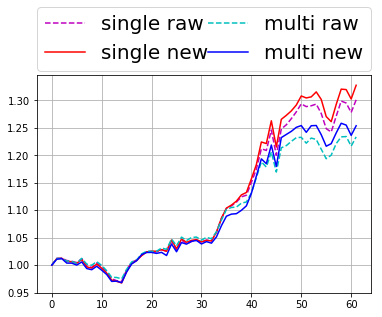

In [180]:
plt.plot(range(len(single_raw_result)), single_raw_result/10000, 'm--', label='single raw')
plt.plot(range(len(single_new_result)), single_new_result/10000, 'r-', label='single new')
plt.plot(range(len(single_raw_result)), np.array(lr_raw_result)/10000, 'c--', label='multi raw')
plt.plot(range(len(single_new_result)), a/10000, 'b-', label='multi new')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0., fontsize=20)
plt.grid(True)
plt.savefig('profit_2014', bbox_inches = 'tight')

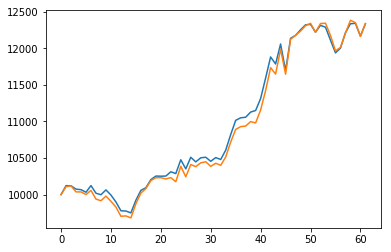

In [158]:
plt.plot(range(len(single_raw_result)), lr_raw_result, range(len(single_new_result)), lr_new_result)
plt.show()